In [29]:
!pip install -U keras-tuner

import pandas as pd
import numpy as np
from keras.datasets import boston_housing
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization
from kerastuner.engine import hyperparameters
from keras.layers import Dropout
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import time
import math
import matplotlib.pyplot as plt
from keras import utils


Requirement already up-to-date: keras-tuner in /usr/local/lib/python3.6/dist-packages (1.0.1)


In [30]:
TRAIN_FILE_PATH = '/content/drive/My Drive/ИАД/train.csv'

# загружаем данные
x = pd.read_csv(TRAIN_FILE_PATH) 

x

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,...,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,8405,107.39,ak,s,as,c,d,aa,d,q,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4205,8406,108.77,j,o,t,d,d,aa,h,h,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4206,8412,109.22,ak,v,r,a,d,aa,g,e,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4207,8415,87.48,al,r,e,f,d,aa,l,u,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [31]:
# функция извлекает правильные значение из тренировочных данных
def get_truth(array):
  data = []
  for col_name, col_info in array.items():
    # находится столбец y
    if col_name == "y":
      # все данные из него пререписываются в массив
      for line_number, line_info in col_info.items():
        temp_array = []
        temp_array.append(line_info)
        data.append(temp_array)
  # массив трансформируется в numpy и меняется его размерность
  return np.array(data, dtype=np.float64).reshape(array.shape[0], 1)


y = get_truth(x)
y

array([[130.81],
       [ 88.53],
       [ 76.26],
       ...,
       [109.22],
       [ 87.48],
       [110.85]])

In [32]:
# столбцы 'y' и 'ID' не нужны при работе больше
x.drop('y', axis='columns', inplace=True)
x.drop('ID', axis='columns', inplace=True)
x

,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,...,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,k,v,at,a,d,u,j,o,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,k,t,av,e,d,y,l,o,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,az,w,n,c,d,x,j,x,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,az,t,n,f,d,x,l,e,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,az,v,n,f,d,h,d,n,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,ak,s,as,c,d,aa,d,q,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4205,j,o,t,d,d,aa,h,h,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4206,ak,v,r,a,d,aa,g,e,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4207,al,r,e,f,d,aa,l,u,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [33]:
# все буквы и цифры шифруются, чтобы остались только числа
df = pd.DataFrame(x)
x = df.apply(preprocessing.LabelEncoder().fit_transform)

x

,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,...,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,32,23,17,0,3,24,9,14,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,32,21,19,4,3,28,11,14,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,20,24,34,2,3,27,9,23,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,20,21,34,5,3,27,11,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,20,23,34,5,3,12,3,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,8,20,16,2,3,0,3,16,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4205,31,16,40,3,3,0,7,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4206,8,23,38,0,3,0,6,4,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4207,9,19,25,5,3,0,11,20,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [34]:
# функция нормализуем данные для работы
def normalize_data(data):
  mean = data.mean(axis=0)
  std = data.std(axis=0)
  data -= mean
  data /= std
  return data

  
x_norm = normalize_data(x)
x_norm

,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,...,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0.162993,1.393322,-0.028118,-1.678071,0.028935,1.291964,0.751698,0.339405,-0.116108,NaN,-0.284872,4.03065,-0.865143,-0.021801,-0.051183,-0.087517,11.247906,-0.332457,-0.408087,19.533195,-0.30857,-0.145263,-0.043633,-0.070803,-1.466267,-0.183402,-0.211955,-0.067331,1.817387,-0.106254,-0.015414,-0.074116,1.817387,-0.067331,1.817387,-0.185468,-0.015414,-0.026704,-0.107392,-0.015414,...,-0.151122,-0.223329,NaN,-4.237357,-0.216803,-0.715734,-0.650246,-0.239287,-0.046286,1.981827,-0.783412,-0.468232,-0.034483,-0.863046,-0.181316,-0.287786,0.187514,-1.041363,-1.749861,-0.053465,-0.053465,-0.034483,-0.233688,-0.258659,-0.021801,-0.081825,-0.120241,-0.021801,-0.140062,-0.542412,-0.684086,-0.246417,1.475156,-0.145263,-0.097941,-0.090232,-0.087517,-0.04081,-0.021801,-0.037778
1,0.162993,1.158883,0.155369,0.620896,0.028935,1.776763,1.437340,0.339405,-0.116108,NaN,-0.284872,-0.24804,-0.865143,-0.021801,-0.051183,-0.087517,11.247906,-0.332457,-0.408087,-0.051183,-0.30857,-0.145263,-0.043633,-0.070803,0.681842,-0.183402,-0.211955,-0.067331,1.817387,-0.106254,-0.015414,-0.074116,1.817387,-0.067331,1.817387,-0.185468,-0.015414,-0.026704,-0.107392,-0.015414,...,-0.151122,-0.223329,NaN,0.235940,-0.216803,-0.715734,-0.650246,-0.239287,-0.046286,-0.504465,-0.783412,-0.468232,-0.034483,-0.863046,-0.181316,-0.287786,0.187514,-1.041363,0.571338,-0.053465,-0.053465,-0.034483,-0.233688,-0.258659,-0.021801,-0.081825,-0.120241,-0.021801,-0.140062,-0.542412,1.461457,-0.246417,-0.677733,-0.145263,-0.097941,-0.090232,-0.087517,-0.04081,-0.021801,-0.037778
2,-0.710475,1.510542,1.531527,-0.528587,0.028935,1.655563,0.751698,1.618197,-0.116108,NaN,-0.284872,-0.24804,-0.865143,-0.021801,-0.051183,11.423670,-0.088884,-0.332457,-0.408087,-0.051183,-0.30857,-0.145263,-0.043633,-0.070803,0.681842,5.451199,4.716869,-0.067331,1.817387,-0.106254,-0.015414,-0.074116,1.817387,-0.067331,1.817387,-0.185468,-0.015414,-0.026704,-0.107392,-0.015414,...,-0.151122,-0.223329,NaN,0.235940,-0.216803,1.396835,-0.650246,-0.239287,-0.046286,1.981827,-0.783412,-0.468232,-0.034483,1.158412,-0.181316,-0.287786,0.187514,-1.041363,0.571338,-0.053465,-0.053465,-0.034483,-0.233688,-0.258659,-0.021801,-0.081825,-0.120241,-0.021801,-0.140062,-0.542412,-0.684086,-0.246417,-0.677733,-0.145263,-0.097941,-0.090232,11.423670,-0.04081,-0.021801,-0.037778
3,-0.710475,1.158883,1.531527,1.195637,0.028935,1.655563,1.437340,-1.081476,-0.116108,NaN,-0.284872,-0.24804,-0.865143,-0.021801,-0.051183,-0.087517,-0.088884,-0.332457,-0.408087,-0.051183,-0.30857,-0.145263,-0.043633,-0.070803,0.681842,5.451199,4.716869,-0.067331,1.817387,-0.106254,-0.015414,-0.074116,1.817387,-0.067331,1.817387,-0.185468,-0.015414,-0.026704,-0.107392,-0.015414,...,-0.151122,-0.223329,NaN,0.235940,-0.216803,1.396835,-0.650246,-0.239287,-0.046286,-0.504465,-0.783412,-0.468232,-0.034483,1.158412,-0.181316,-0.287786,0.187514,-1.041363,0.571338,-0.053465,-0.053465,-0.034483,-0.233688,-0.258659,-0.021801,-0.081825,-0.120241,45.858481,-0.140062,-0.542412,-0.684086,-0.246417,-0.677733,-0.145263,-0.097941,-0.090232,-0.087517,-0.04081,-0.021801,-0.037778
4,-0.710475,1.393322,1.531527,1.195637,0.028935,-0.162435,-1.305229,0.197316,-0.116108,NaN,-0.284872,-0.24804,-0.865143,-0.021801,-0.051183,-0.087517,-0.088884,-0.332457,-0.408087,-0.051183,-0.30857,-0.145263,-0.043633,-0.070803,0.681842,5.451199,4.716869,-0.067331,1.817387,-0.106254,-0.015414,-0.074116,1.817387,-0.067331,1.817387,-0.185468,-0.015414,-0.026704,-0.107392,-0.015414,...,-0.151122,-0.223329,NaN,0.235940,-0.216803,1.396835,-0.650246,-0.239287,-0.046286,-0.504465,-0.783412,-0.468232,-0.034483,1.158412,-0.181316,-0.287786,0.187

In [35]:
def check_nans(data):
  # массив названий столбцов, в которых одни NaN
  nan_cols = []
  for col_name, col_info in data.items():
    for line_number, line_info in col_info.items():
      if math.isnan(line_info):
        print(f"{col_name } is NaNs")
        nan_cols.append(col_name)
        break
  if nan_cols == []:
    print("[INFO] THERE IS NO NaNS IN DATA!")
  return nan_cols

nan_cols = check_nans(x_norm)

X11 is NaNs
X93 is NaNs
X107 is NaNs
X233 is NaNs
X235 is NaNs
X268 is NaNs
X289 is NaNs
X290 is NaNs
X293 is NaNs
X297 is NaNs
X330 is NaNs
X347 is NaNs


In [36]:
def delete_nans(data, nan_cols):
  for col in nan_cols:
    try:
      x.drop(str(col), axis='columns', inplace=True)
    except:
      continue

delete_nans(x_norm, nan_cols)

In [37]:
check_nans(x_norm)

[INFO] THERE IS NO NaNS IN DATA!


[]

In [38]:
# делим в соотношении 70 на 30
(x_train, x_test) = train_test_split(x_norm, test_size=0.3)
(y_train, y_test) = train_test_split(y, test_size=0.3)

In [39]:

# функция принимает данные, прочитанные из csv файла, переводит их в numpy_array
def convert_csv_to_numpy(array):
  array_to_convert = []
  for col_name, col_info in array.items():
    # временный массив создается для каждого СТОЛБЦА
    temp_array = []
    for line_number, line_info in col_info.items():
        temp_array.append(line_info)
    # после прохождения всего столбца временный массив добавляется в основной
    if temp_array != []:
      array_to_convert.append(temp_array)
  # в самом конце основном массив конвертируется в numpy_array
  return np.array(array_to_convert, dtype=np.float64)


x_train = convert_csv_to_numpy(x_train) 
x_test = convert_csv_to_numpy(x_test)


In [40]:
x_train

array([[-0.05537429,  0.38135975,  0.09020372, ..., -0.71047536,
        -0.78326436,  0.74530478],
       [ 0.92444416,  0.22112691, -1.18550759, ...,  1.62776141,
        -1.18550759, -0.95106851],
       [ 1.07280786, -0.11986205, -1.03730044, ..., -0.30334973,
        -0.11986205, -1.31253196],
       ...,
       [-0.04081026, -0.04081026, -0.04081026, ..., -0.04081026,
        -0.04081026, -0.04081026],
       [-0.02180104, -0.02180104, -0.02180104, ..., -0.02180104,
        -0.02180104, -0.02180104],
       [-0.03777847, -0.03777847, -0.03777847, ..., -0.03777847,
        -0.03777847, -0.03777847]])

In [41]:
x_test

array([[-0.78326436,  0.38135975, -0.20095231, ...,  1.03646081,
         1.10924982, -1.65673245],
       [-0.13053172,  1.39332233,  1.0416637 , ...,  1.39332233,
         0.92444416,  0.22112691],
       [-0.11986205, -0.85381276,  1.43978322, ...,  0.24711331,
         0.79757634, -0.11986205],
       ...,
       [-0.04081026, -0.04081026, -0.04081026, ..., -0.04081026,
        -0.04081026, -0.04081026],
       [-0.02180104, -0.02180104, -0.02180104, ..., -0.02180104,
        -0.02180104, -0.02180104],
       [-0.03777847, -0.03777847, -0.03777847, ..., -0.03777847,
        -0.03777847, -0.03777847]])

In [42]:
# меняю формы обоих x, чтобы первое измерение совпадало с y
x_train = np.reshape(x_train, (x_train.shape[1], x_train.shape[0]))
x_test = np.reshape(x_test, (x_test.shape[1], x_test.shape[0]))

print(f"Y_TRAIN SHAPE IS {y_train.shape}")
print(f"Y_TEST SHAPE IS {y_test.shape}")
print(f"X_TRAIN SHAPE IS {x_train.shape}")
print(f"X_TEST SHAPE IS {x_test.shape}")
print("\n\n")


Y_TRAIN SHAPE IS (2946, 1)
Y_TEST SHAPE IS (1263, 1)
X_TRAIN SHAPE IS (2946, 364)
X_TEST SHAPE IS (1263, 364)





In [43]:
(x_train_main, x_train_val) = train_test_split(x_train, test_size=0.3)
(y_train_main, y_train_val) = train_test_split(y_train, test_size=0.3)

In [44]:
model = Sequential()
model.add(Dense(1024, activation="relu", input_shape=(x_train_main.shape[1],)))
model.add(Dense(512, activation="relu"))
model.add(Dense(1))
print("[INFO] NN has been created")
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
print("[INFO] NN has been compiled")
model.summary()
# начинаем обучение нейронной сети
history = model.fit(x_train_main, y_train_main, epochs=100, batch_size=100, validation_data=(x_train_val, y_train_val))
history = history.history
print("[INFO] Training has been finished")


[INFO] NN has been created
[INFO] NN has been compiled
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              373760    
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 513       
Total params: 899,073
Trainable params: 899,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
21/21 [==============================] - 1s 34ms/step - loss: 2937.9109 - mae: 41.5109 - val_loss: 1637.5646 - val_mae: 27.5914
Epoch 2/100
21/21 [==============================] - 1s 29ms/step - loss: 1185.6228 - mae: 23.5334 - val_loss: 1366.5118 - val_mae: 26.5886
Epoch 3/100
21/21 [========================

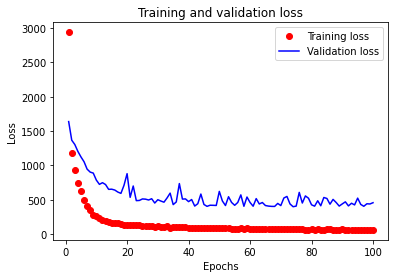

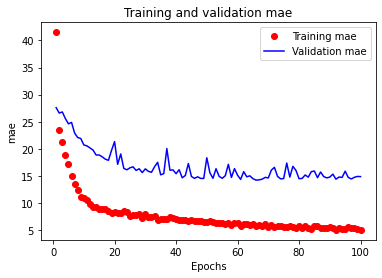

In [45]:
# функция строит графики после тренировки
def draw_graph(history):
    loss_values = history["loss"]
    validation_loss_values = history["val_loss"]

    epochs = range(1, len(history['loss']) + 1)

    #               ГРАФИКИ ПОТЕРЬ
    # синими точками рисуется график потерь на этапе обучения
    plt.plot(epochs, loss_values, 'or', label='Training loss')
    # синей линией рисуется график потерь на этапе проверки
    plt.plot(epochs, validation_loss_values, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # очищаем рисунок
    plt.clf()

    #               ГРАФИКИ ОШИБКИ
    acc_values = history['mae']
    validation_acc_values = history['val_mae']
    plt.plot(epochs, acc_values, 'or', label='Training mae')
    plt.plot(epochs, validation_acc_values, 'b', label='Validation mae')
    plt.title('Training and validation mae')
    plt.xlabel('Epochs')
    plt.ylabel('mae')
    plt.legend()
    plt.show()



# рисуем все графики
draw_graph(history)

In [46]:
print("[INFO] RUNNING ON TEST DATA: \n")
# вычисляем ошибки и выводим их на экран
mse, mae = model.evaluate(x_test, y_test, verbose=1)
print(f"[INFO] Mean squared error is {mse}")
print(f"[INFO] Mean absolute error is {mae}")

[INFO] RUNNING ON TEST DATA: 

40/40 [==============================] - 0s 6ms/step - loss: 512.2417 - mae: 15.2939
[INFO] Mean squared error is 512.24169921875
[INFO] Mean absolute error is 15.293922424316406


In [47]:
# функция создание нейронной сети
def build_NN(hp):
  model = Sequential()
  # варианты активационых функций
  activation_choice = hp.Choice("activation", values=["relu", "sigmoid", "tanh", "elu", "selu"])
  # создаем один входной слой
  model.add(Dense(units=hp.Int("units_input", min_value=32,max_value=1024, step=32), activation=activation_choice, input_dim=364))
  # опционально добавляются еще слои разной конфигурации
  for i in range(hp.Int("n_layers", 2, 3)):
    model.add(Dense(units=hp.Int("units_"+str(i), min_value=32, max_value=1024, step=32), activation=activation_choice))
  # создаем один выходной слой
  model.add(Dense(1))
  # компиляция сети происходит с выборо одного из оптимизаторов
  model.compile(optimizer=hp.Choice("optimizer", values=["adam", "rmsprop", "SGD"]), loss="mse", metrics=["mae"])
  model.summary()
  return model


def find_best_NN(x_train_norm, y_train):
  # создаю тюнер, который сможет подобрать оптимальную архитектуру модели
  tuner = RandomSearch(build_NN, objective="loss", max_trials=20, executions_per_trial=1)
  print("\n\n\n")
  # начинается автоматический подбор гиперпараметров
  print('[INFO] start searching')
  tuner.search(x_train, y_train, batch_size=100, epochs=10, validation_split=0.3)
  # выбираем лучшую модель
  print("\n\n\nRESULTS SUMMARY")
  tuner.results_summary()
  print("\n\n\n")
  # получаем лучшую модель
  print("\n\n\nHERE IS THE BEST MODEL\n\n\n")
  best_model = tuner.get_best_models(num_models=1)[0]

  return best_model
  

best_model = find_best_NN(x_train, y_train)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                11680     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 13,825
Trainable params: 13,825
Non-trainable params: 0
_________________________________________________________________




[INFO] start searching
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              373760    
_____

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               93440     
_________________________________________________________________
dense_1 (Dense)              (None, 864)               222048    
_________________________________________________________________
dense_2 (Dense)              (None, 800)               692000    
_________________________________________________________________
dense_3 (Dense)              (None, 32)                25632     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,033,153
Trainable params: 1,033,153
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
21/21 [==============================] - 1s 36ms/step - loss: nan - mae: nan - val_loss: nan - val_ma

/usr/local/lib/python3.6/dist-packages/kerastuner/engine/metrics_tracking.py:92: RuntimeWarning: All-NaN axis encountered
  return np.nanmin(values)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 224)               81760     
_________________________________________________________________
dense_1 (Dense)              (None, 576)               129600    
_________________________________________________________________
dense_2 (Dense)              (None, 192)               110784    
_________________________________________________________________
dense_3 (Dense)              (None, 608)               117344    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 609       
Total params: 440,097
Trainable params: 440,097
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
21/21 [==============================] - 0s 21ms/step - loss: 8087.3311 - mae: 79.3180 - val_loss: 1068.4

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               93440     
_________________________________________________________________
dense_1 (Dense)              (None, 896)               230272    
_________________________________________________________________
dense_2 (Dense)              (None, 736)               660192    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                47168     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 1,031,137
Trainable params: 1,031,137
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
21/21 [==============================] - 1s 34ms/step - loss: 9906.9277 - mae: 98.5103 - val_loss: 95

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 160)               58400     
_________________________________________________________________
dense_1 (Dense)              (None, 160)               25760     
_________________________________________________________________
dense_2 (Dense)              (None, 800)               128800    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 801       
Total params: 213,761
Trainable params: 213,761
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
21/21 [==============================] - 0s 18ms/step - loss: 9620.6211 - mae: 96.7601 - val_loss: 8446.3945 - val_mae: 89.0395
Epoch 2/10
21/21 [==============================] - 0s 13ms/step - loss: 5924.7163 - mae: 70.2661 - val_loss:

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               46720     
_________________________________________________________________
dense_1 (Dense)              (None, 992)               127968    
_________________________________________________________________
dense_2 (Dense)              (None, 640)               635520    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 641       
Total params: 810,849
Trainable params: 810,849
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
21/21 [==============================] - 1s 28ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/10
21/21 [==============================] - 1s 25ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/10

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 480)               175200    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               153920    
_________________________________________________________________
dense_2 (Dense)              (None, 384)               123264    
_________________________________________________________________
dense_3 (Dense)              (None, 416)               160160    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 417       
Total params: 612,961
Trainable params: 612,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
21/21 [==============================] - 1s 28ms/step - loss: 2469.0537 - mae: 37.3078 - val_loss: 764.98

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 704)               256960    
_________________________________________________________________
dense_1 (Dense)              (None, 928)               654240    
_________________________________________________________________
dense_2 (Dense)              (None, 96)                89184     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 97        
Total params: 1,000,481
Trainable params: 1,000,481
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
21/21 [==============================] - 1s 33ms/step - loss: 4317.8833 - mae: 54.4784 - val_loss: 2291.2854 - val_mae: 35.5461
Epoch 2/10
21/21 [==============================] - 1s 28ms/step - loss: 1709.6587 - mae: 30.1209 - val_l

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               93440     
_________________________________________________________________
dense_1 (Dense)              (None, 192)               49344     
_________________________________________________________________
dense_2 (Dense)              (None, 768)               148224    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 769       
Total params: 291,777
Trainable params: 291,777
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
21/21 [==============================] - 0s 21ms/step - loss: 5780.7710 - mae: 68.0757 - val_loss: 3697.0752 - val_mae: 44.0541
Epoch 2/10
21/21 [==============================] - 0s 15ms/step - loss: 1958.1577 - mae: 32.2800 - val_loss:

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 992)               362080    
_________________________________________________________________
dense_1 (Dense)              (None, 736)               730848    
_________________________________________________________________
dense_2 (Dense)              (None, 480)               353760    
_________________________________________________________________
dense_3 (Dense)              (None, 32)                15392     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,462,113
Trainable params: 1,462,113
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
21/21 [==============================] - 1s 45ms/step - loss: 4225.4590 - mae: 54.5388 - val_loss: 20

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 736)               268640    
_________________________________________________________________
dense_1 (Dense)              (None, 704)               518848    
_________________________________________________________________
dense_2 (Dense)              (None, 384)               270720    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 385       
Total params: 1,058,593
Trainable params: 1,058,593
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
21/21 [==============================] - 1s 40ms/step - loss: 7092.0449 - mae: 75.7950 - val_loss: 4831.5342 - val_mae: 57.8621
Epoch 2/10
21/21 [==============================] - 1s 36ms/step - loss: 2915.2031 - mae: 43.3515 - val_l

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               233600    
_________________________________________________________________
dense_1 (Dense)              (None, 288)               184608    
_________________________________________________________________
dense_2 (Dense)              (None, 992)               286688    
_________________________________________________________________
dense_3 (Dense)              (None, 704)               699072    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 705       
Total params: 1,404,673
Trainable params: 1,404,673
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
21/21 [==============================] - 1s 44ms/step - loss: 6981.7773 - mae: 82.3036 - val_loss: 58

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 864)               315360    
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              885760    
_________________________________________________________________
dense_2 (Dense)              (None, 288)               295200    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 289       
Total params: 1,496,609
Trainable params: 1,496,609
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
21/21 [==============================] - 1s 51ms/step - loss: 9514.6729 - mae: 95.1846 - val_loss: 8904.8203 - val_mae: 91.0533
Epoch 2/10
21/21 [==============================] - 1s 47ms/step - loss: 7210.7642 - mae: 81.0132 - val_l

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 576)               210240    
_________________________________________________________________
dense_1 (Dense)              (None, 832)               480064    
_________________________________________________________________
dense_2 (Dense)              (None, 768)               639744    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 769       
Total params: 1,330,817
Trainable params: 1,330,817
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
21/21 [==============================] - 1s 47ms/step - loss: 9735.5693 - mae: 96.8753 - val_loss: 9018.6162 - val_mae: 90.7253
Epoch 2/10
21/21 [==============================] - 1s 38ms/step - loss: 6134.4277 - mae: 71.0732 - val_l

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 736)               268640    
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              754688    
_________________________________________________________________
dense_2 (Dense)              (None, 608)               623200    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 609       
Total params: 1,647,137
Trainable params: 1,647,137
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
21/21 [==============================] - 1s 53ms/step - loss: 8202.1914 - mae: 83.5085 - val_loss: 6213.7749 - val_mae: 61.1138
Epoch 2/10
21/21 [==============================] - 1s 50ms/step - loss: 3286.6252 - mae: 44.4109 - val_l

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 384)               140160    
_________________________________________________________________
dense_1 (Dense)              (None, 384)               147840    
_________________________________________________________________
dense_2 (Dense)              (None, 640)               246400    
_________________________________________________________________
dense_3 (Dense)              (None, 384)               246144    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 385       
Total params: 780,929
Trainable params: 780,929
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
21/21 [==============================] - 1s 35ms/step - loss: 2915.1975 - mae: 40.2916 - val_loss: 2212.5

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 736)               268640    
_________________________________________________________________
dense_1 (Dense)              (None, 608)               448096    
_________________________________________________________________
dense_2 (Dense)              (None, 416)               253344    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 417       
Total params: 970,497
Trainable params: 970,497
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
21/21 [==============================] - 1s 62ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/10
21/21 [==============================] - 1s 52ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/10

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 992)               362080    
_________________________________________________________________
dense_1 (Dense)              (None, 640)               635520    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               82048     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 1,079,777
Trainable params: 1,079,777
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
21/21 [==============================] - 1s 37ms/step - loss: 5168.6064 - mae: 63.8111 - val_loss: 3465.1204 - val_mae: 40.0529
Epoch 2/10
21/21 [==============================] - 1s 38ms/step - loss: 1689.2898 - mae: 31.4684 - val_l

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 896)               327040    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               459264    
_________________________________________________________________
dense_2 (Dense)              (None, 768)               393984    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 769       
Total params: 1,181,057
Trainable params: 1,181,057
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
21/21 [==============================] - 1s 35ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/10
21/21 [==============================] - 1s 30ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 224)               81760     
_________________________________________________________________
dense_1 (Dense)              (None, 896)               201600    
_________________________________________________________________
dense_2 (Dense)              (None, 896)               803712    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 897       
Total params: 1,087,969
Trainable params: 1,087,969
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
21/21 [==============================] - 1s 34ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/10
21/21 [==============================] - 1s 30ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 

INFO:tensorflow:Oracle triggered exit



RESULTS SUMMARY









HERE IS THE BEST MODEL



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              373760    
_________________________________________________________________
dense_1 (Dense)              (None, 928)               951200    
_________________________________________________________________
dense_2 (Dense)              (None, 288)               267552    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 289       
Total params: 1,592,801
Trainable params: 1,592,801
Non-trainable params: 0
_________________________________________________________________


In [48]:
# примерно на 13 эпохе переобучение
history = best_model.fit(x_train_main, y_train_main, epochs=100, batch_size=100, validation_data=(x_train_val, y_train_val))
best_history = history.history
print("[INFO] Training has been finished")

Epoch 1/100
21/21 [==============================] - 1s 44ms/step - loss: 469.1878 - mae: 15.8626 - val_loss: 587.4328 - val_mae: 17.6244
Epoch 2/100
21/21 [==============================] - 1s 39ms/step - loss: 234.5002 - mae: 11.3284 - val_loss: 494.2942 - val_mae: 16.0972
Epoch 3/100
21/21 [==============================] - 1s 40ms/step - loss: 135.9267 - mae: 8.0376 - val_loss: 477.3976 - val_mae: 15.7261
Epoch 4/100
21/21 [==============================] - 1s 39ms/step - loss: 93.1871 - mae: 6.2060 - val_loss: 440.3978 - val_mae: 15.1712
Epoch 5/100
21/21 [==============================] - 1s 42ms/step - loss: 76.7292 - mae: 5.3307 - val_loss: 429.5936 - val_mae: 15.1162
Epoch 6/100
21/21 [==============================] - 1s 37ms/step - loss: 68.0996 - mae: 4.8359 - val_loss: 465.4979 - val_mae: 15.3928
Epoch 7/100
21/21 [==============================] - 1s 37ms/step - loss: 64.5351 - mae: 4.6840 - val_loss: 433.2828 - val_mae: 15.1357
Epoch 8/100
21/21 [========================

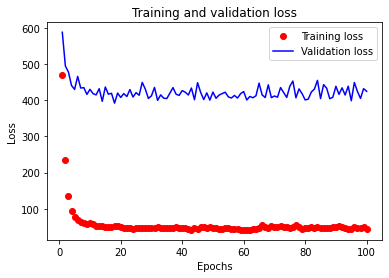

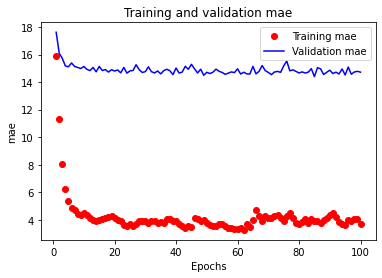

In [49]:
# рисуем все графики
draw_graph(best_history)

In [50]:
best_model.evaluate(x_test, y_test, verbose=1)

40/40 [==============================] - 0s 8ms/step - loss: 647.4559 - mae: 16.4585


[647.4559326171875, 16.45853042602539]